## 1. Chargement des données

In [ ]:
# Importation des librairies nécessaires pour l'analyse
import pandas as pd

# Chargement des données avec le bon séparateur (;)
df = pd.read_csv('billets.csv', sep=';')

# Affichage des 5 premières lignes pour vérifier la structure
df.head()


is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

## 2. Aperçu général du jeu de données


In [ ]:
# Dimensions du jeu de données (lignes, colonnes)
print("Dimensions du jeu de données :", df.shape)

# Types des colonnes et nombre de valeurs non nulles
print("\nInformations générales sur les colonnes :")
df.info()

# Nombre de valeurs manquantes par colonne
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Valeurs possibles pour la variable cible 'is_genuine'
print("\nValeurs uniques dans 'is_genuine' :")
print(df['is_genuine'].unique())

print("\nNombre d'occurrences de chaque valeur dans 'is_genuine' :")
print(df['is_genuine'].value_counts())


Dimensions du jeu de données : (1500, 7)

Informations générales sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB

Valeurs manquantes par colonne :
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Valeurs uniques dans 'is_genuine' :
[ True False]

Nombre d'occurrences de chaque valeur dans 'is_genuine' :
is_genuine
True     1000
False     500
Name: count, dtype: int64


## 3. Statistiques descriptives et visualisation des variables


          diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000  


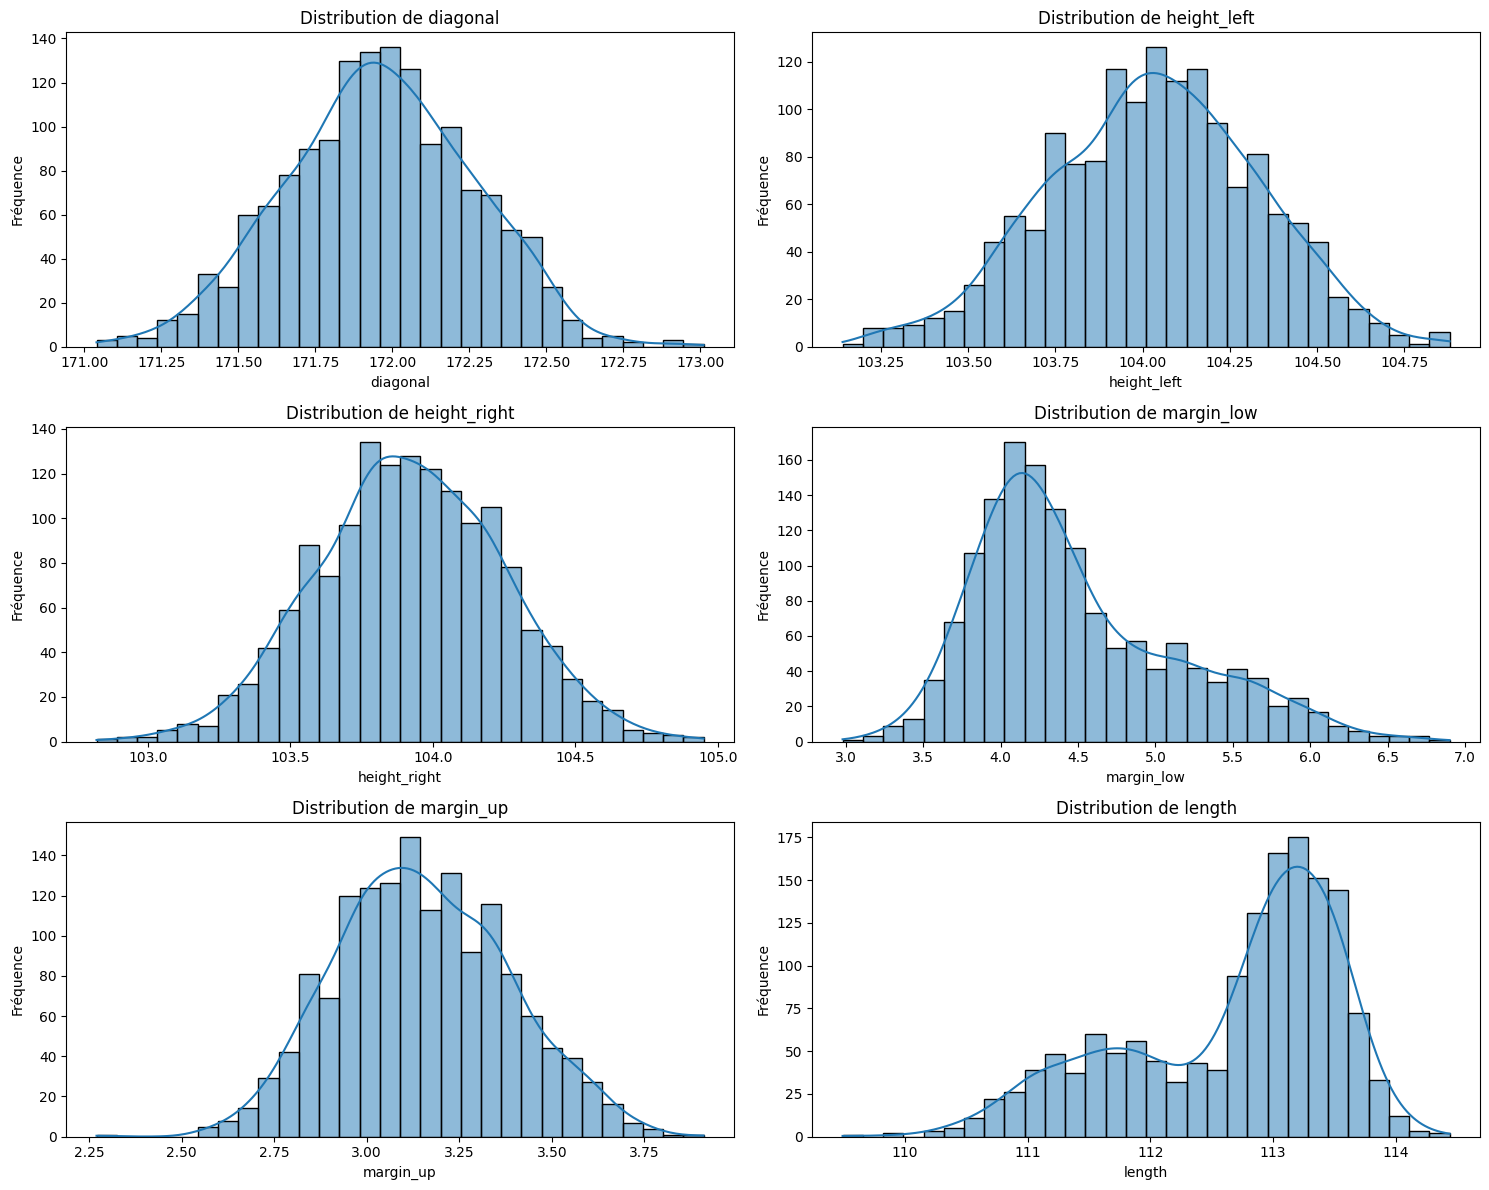

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques descriptives de base pour les variables numériques
desc_stats = df.describe()
print(desc_stats)

# Liste des variables géométriques à visualiser
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Affichage des histogrammes avec courbe de densité (KDE)
plt.figure(figsize=(15, 12))
for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=df, x=col, bins=30, kde=True)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()


- Les variables géométriques semblent bien réparties, avec des distributions globalement normales (ex : `diagonal`, `height_left`, `height_right`).
- `margin_low` est un peu asymétrique, légèrement biaisée vers la droite.
- La variable `length` a une distribution un peu particulière, légèrement bimodale. Cela pourrait être une piste intéressante à explorer plus tard pour différencier vrais et faux billets.
- Ces premières analyses ne permettent pas encore de savoir ce qui distingue les vrais des faux billets : pour cela, il faudra comparer les variables **en fonction de la classe cible (`is_genuine`)**.


## 4. Comparaison des variables entre vrais et faux billets


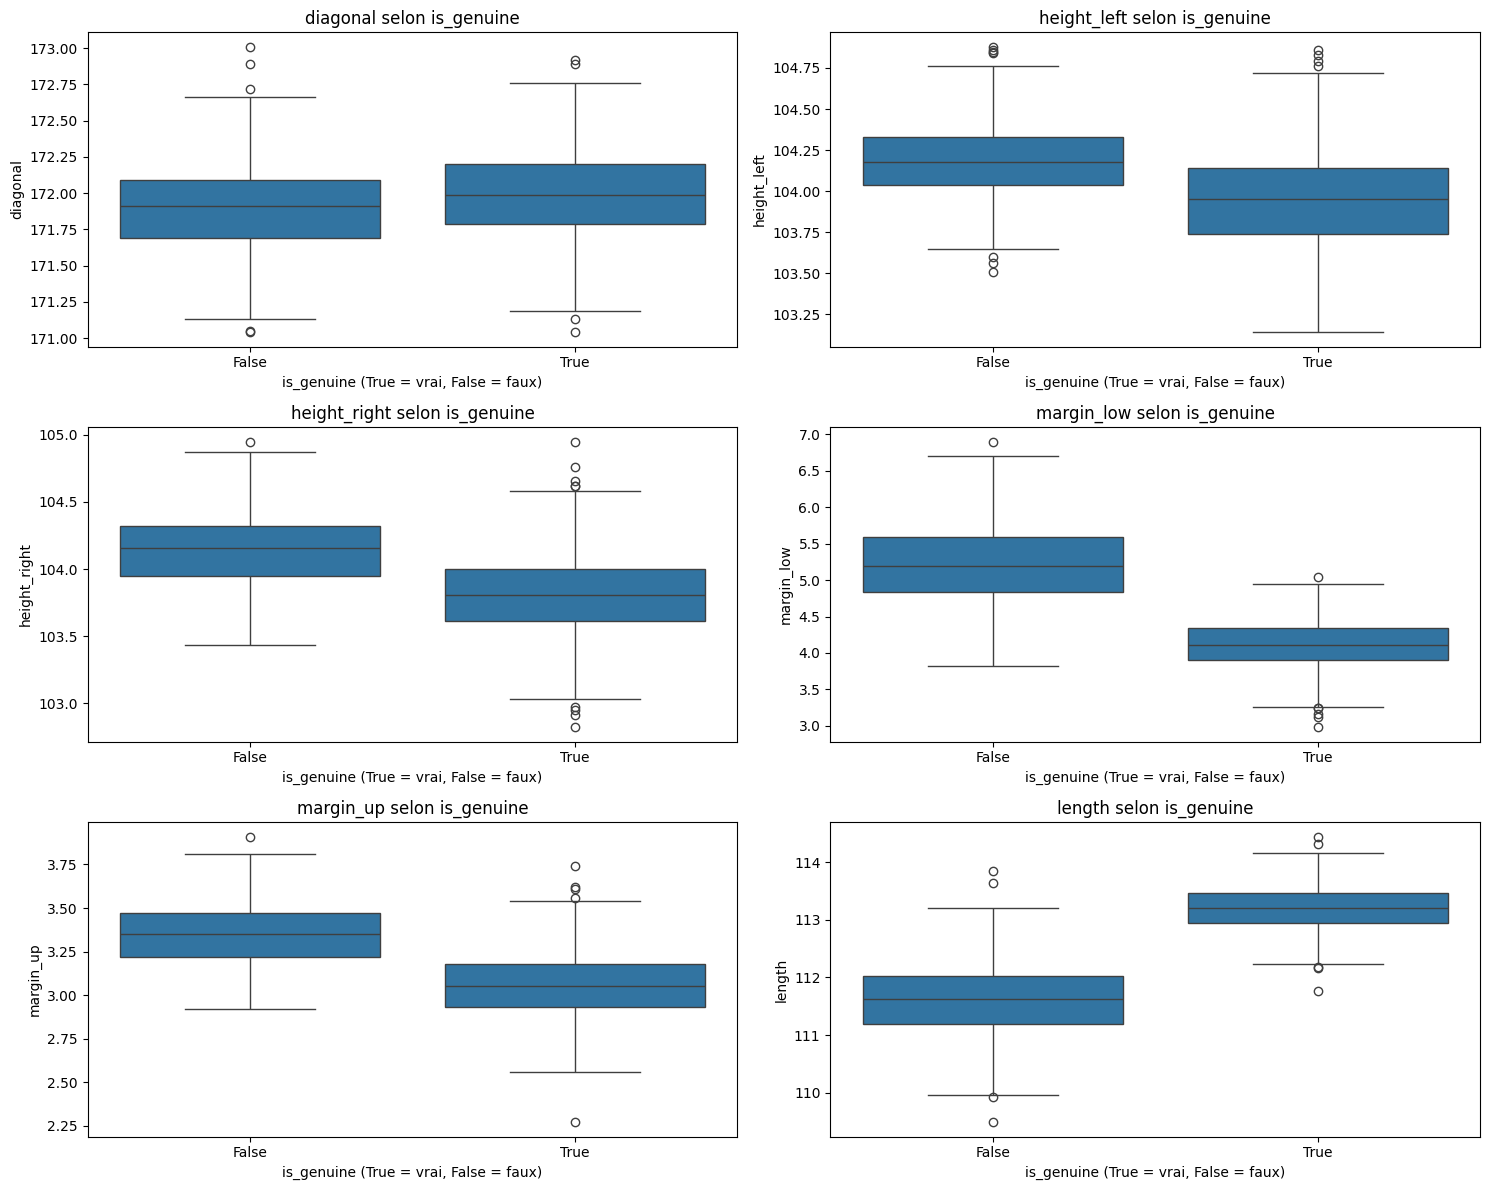

In [ ]:
# Affichage de boxplots pour comparer les variables entre vrais et faux billets

features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

plt.figure(figsize=(15, 12))
for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(data=df, x='is_genuine', y=col)
    plt.title(f'{col} selon is_genuine')
    plt.xlabel('is_genuine (True = vrai, False = faux)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


- Les faux billets (`is_genuine = False`) ont en moyenne une **marge basse (margin_low)** plus élevée que les vrais.
- Les vrais billets ont tendance à avoir une **longueur (length)** plus grande que les faux.
- `margin_up` et `height_right` montrent aussi des différences légères.
- Ces différences suggèrent que certaines variables sont potentiellement **discriminantes**, et seront utiles pour la modélisation.


## 5. Régression linéaire pour prédire margin_low


In [ ]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import shapiro

# Entraînement sur les données sans valeurs manquantes
df_reg = df.dropna(subset=['margin_low'])
X = df_reg.drop(columns=['is_genuine', 'margin_low'])
y = df_reg['margin_low']

# Ajout d'une constante pour le modèle (intercept)
X_const = sm.add_constant(X)

# Régression linéaire
model = sm.OLS(y, X_const).fit()
y_pred = model.predict(X_const)
residuals = y - y_pred

# Évaluation du modèle
print("R² :", r2_score(y, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y, y_pred)))

# Test de normalité des résidus
print("Test de Shapiro-Wilk sur les résidus :", shapiro(residuals))

# Résumé détaillé
model.summary()



R² : 0.47733669730639583
RMSE : 0.4797423242719384
Test de Shapiro-Wilk sur les résidus : ShapiroResult(statistic=np.float64(0.9857882577573774), pvalue=np.float64(8.540407842384949e-11))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 21 May 2025   Prob (F-statistic):          2.60e-202
Time:                        16:19:36   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382      0.017       4.055      41.935
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Le R² obtenu est de 0.477, ce qui signifie que le modèle explique environ 48 % de la variance de la variable `margin_low`.
- Le RMSE est de 0.48 mm, ce qui correspond à une erreur moyenne raisonnable dans le contexte des dimensions d’un billet.
- Tous les coefficients sont significatifs (p < 0.05), et leur signe est interprétable :
  - `length` a un effet négatif marqué : plus un billet est long, plus la marge basse est petite.
  - `height_right` et `height_left` ont un effet positif modéré.
- Le test de Shapiro-Wilk montre que les résidus ne sont **pas parfaitement normaux** (p < 0.05), ce qui est fréquent en pratique.
- Le condition number est très élevé (1.94e+05), ce qui suggère une possible multicolinéarité entre certaines variables (elles sont corrélées entre elles), mais le modèle reste utilisable pour l’imputation.
- On pourrait envisager d'utiliser ce modèle pour **imputer les valeurs manquantes de margin_low** de manière plus fiable qu’une simple moyenne.


In [ ]:
# Test d'homoscédasticité (Breusch-Pagan)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X_const)

print("Test de Breusch-Pagan (homoscédasticité) :")
print("  Statistique :", bp_test[0])
print("  p-value :", bp_test[1])


Test de Breusch-Pagan (homoscédasticité) :
  Statistique : 80.16261280172635
  p-value : 7.759535216285388e-16


Le test de Breusch-Pagan indique une p-value très faible (< 0.05), ce qui signifie que les résidus ne sont pas homoscédastiques.  
Cela confirme que l’hypothèse d’homoscédasticité n’est pas respectée, ce qui est fréquent en pratique.  
Dans ce contexte, cela n’empêche pas d’utiliser ce modèle comme outil d’imputation pour la variable `margin_low`, car l’objectif n’est pas de faire des inférences mais de produire une estimation raisonnable.


## 6. Imputation des valeurs manquantes de margin_low avec le modèle de régression


In [ ]:
# 1. Séparer les lignes où margin_low est manquant
df_missing = df[df['margin_low'].isnull()].copy()

# 2. Préparer les variables d’entrée (comme pour l'entraînement)
X_missing = df_missing.drop(columns=['is_genuine', 'margin_low'])
X_missing_const = sm.add_constant(X_missing)  # ajout de la constante

# 3. Prédire les valeurs manquantes avec le modèle
predicted_margin_low = model.predict(X_missing_const)

# 4. Créer une copie du DataFrame et y insérer les valeurs prédites
df_imputed = df.copy()
df_imputed.loc[df_imputed['margin_low'].isnull(), 'margin_low'] = predicted_margin_low

# 5. Vérifier qu’il n’y a plus de valeur manquante
print("Valeurs manquantes restantes dans margin_low :", df_imputed['margin_low'].isnull().sum())


Valeurs manquantes restantes dans margin_low : 0


## 7. Préparation des données pour l’apprentissage supervisé


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Séparer les variables explicatives (X) et la variable cible (y)
X = df_imputed.drop(columns=['is_genuine'])  # Toutes les dimensions géométriques
y = df_imputed['is_genuine']  # Ce qu'on veut prédire (True = vrai billet, False = faux billet)

# 2. Diviser les données en un jeu d'entraînement et un jeu de test (80 % / 20 %)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Normalisation des variables explicatives
# (obligatoire pour KNN et régression logistique)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Vérification des dimensions
print("Dimensions du jeu d'entraînement :", X_train.shape)
print("Dimensions du jeu de test :", X_test.shape)


Dimensions du jeu d'entraînement : (1200, 6)
Dimensions du jeu de test : (300, 6)


Nous avons séparé les variables explicatives des billets (dimensions) et la variable cible à prédire (`is_genuine`).  
Les données ont été divisées en un jeu d'entraînement (80 %) et un jeu de test (20 %), afin de pouvoir évaluer la capacité du modèle à généraliser.  
Enfin, les variables explicatives ont été normalisées (centrage-réduction) pour assurer un bon fonctionnement des algorithmes sensibles à l’échelle comme la régression logistique ou le KNN.

Le jeu d'entraînement contient 1200 billets, et le jeu de test en contient 300.


## 8. Régression logistique


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# 1. Entraînement du modèle
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

# 2. Prédiction sur le jeu de test
y_pred_logreg = logreg.predict(X_test_scaled)

# 3. Évaluation du modèle
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_logreg))


Matrice de confusion :
[[108   2]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       110
        True       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Nous avons entraîné un modèle de régression logistique pour prédire si un billet est vrai ou faux à partir de ses dimensions.

La matrice de confusion obtenue est la suivante :

- 108 faux billets ont été correctement prédits comme faux (vrais négatifs)
- 190 vrais billets ont été correctement prédits comme vrais (vrais positifs)
- 2 faux billets ont été incorrectement classés comme vrais (faux négatifs)
- Aucun vrai billet n’a été classé à tort comme faux (0 faux positifs)

Le rapport de classification montre une **précision globale de 99 %**.  
Les scores de **précision**, **rappel** et **f1-score** sont excellents pour les deux classes (`False` et `True`), avec un **f1-score à 0.99** dans chaque cas.

Ces résultats indiquent que le modèle est très performant pour différencier les vrais des faux billets.


## 9. Modèle KNN (K-Nearest Neighbors)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1. Création et entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# 2. Prédictions sur le jeu de test
y_pred_knn = knn.predict(X_test_scaled)

# 3. Évaluation du modèle
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_knn))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_knn))


Matrice de confusion :
[[105   5]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

       False       1.00      0.95      0.98       110
        True       0.97      1.00      0.99       190

    accuracy                           0.98       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Nous avons entraîné un modèle K-Nearest Neighbors (KNN) avec k = 5.  
Ce modèle classe chaque billet en fonction des 5 billets les plus proches dans l’espace des dimensions géométriques. Il repose sur l’hypothèse que des billets aux dimensions similaires ont la même nature (vrai ou faux).

La matrice de confusion obtenue est la suivante :

- 105 faux billets correctement identifiés comme faux (vrais négatifs)
- 190 vrais billets correctement identifiés comme vrais (vrais positifs)
- 5 faux billets mal classés comme vrais (faux négatifs)
- Aucun vrai billet mal classé comme faux (faux positifs = 0)

Le rapport de classification montre :
- une **précision de 100 %** pour les billets `False` (faux), mais un **rappel de 95 %** car 5 ont été ratés
- une **précision de 97 %** pour les billets `True` (vrais), avec un **rappel parfait (100 %)**
- un **score F1 moyen de 98 %**, ce qui confirme une très bonne performance globale

Ces résultats sont légèrement moins bons que la régression logistique, mais restent très élevés.




## 10. Modèle Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1. Création du modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# 2. Entraînement
rf.fit(X_train_scaled, y_train)

# 3. Prédictions
y_pred_rf = rf.predict(X_test_scaled)

# 4. Évaluation
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_rf))


Matrice de confusion :
[[108   2]
 [  0 190]]

Rapport de classification :
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       110
        True       0.99      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Nous avons entraîné un modèle Random Forest pour prédire la nature des billets.  
Ce modèle combine plusieurs arbres de décision : chaque arbre vote pour dire si un billet est vrai ou faux, ce qui rend la prédiction plus stable et robuste.

La matrice de confusion obtenue est la suivante :

- 108 faux billets ont été bien détectés comme faux (vrais négatifs)
- 190 vrais billets ont été bien détectés comme vrais (vrais positifs)
- 2 faux billets ont été mal classés comme vrais (faux négatifs)
- Aucun vrai billet n’a été classé à tort comme faux (faux positifs = 0)

Le rapport de classification indique :
- une **précision parfaite (1.00)** pour la classe `False` (faux billets), et une **rappel de 0.98**
- une **précision de 0.99** et un **rappel parfait (1.00)** pour les billets `True` (vrais billets)
- un **f1-score moyen de 0.99**, ce qui montre une excellente performance globale

En résumé, Random Forest est légèrement meilleur que KNN et aussi performant que la régression logistique dans ce contexte.




### Validation croisée du modèle Random Forest


In [ ]:
from sklearn.model_selection import cross_val_score

# Validation croisée (5 plis) sur les données d'entraînement
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Résultats
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", round(cv_scores.mean(), 3))


Scores de validation croisée : [0.99166667 0.99583333 0.9875     0.99166667 0.99166667]
Score moyen : 0.992


Pour compléter l’évaluation du modèle Random Forest, nous avons effectué une validation croisée en 5 plis sur les données d’entraînement.

Cela permet de vérifier la robustesse du modèle sur différents sous-échantillons, et d’éviter que ses performances ne dépendent d’un unique découpage train/test.

Les scores obtenus sur les 5 plis sont excellents, avec une précision comprise entre **0.9875** et **0.9958**, et une **moyenne de 0.992**.  
Cela confirme que le modèle est **très stable** et **hautement performant** sur l’ensemble des données.


## 11. Méthode non supervisée — K-means (k=2)


In [ ]:
from sklearn.cluster import KMeans

# 1. Création et entraînement du modèle KMeans avec k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
clusters_kmeans = kmeans.fit_predict(X_train_scaled)

# 2. Création d’un nouveau DataFrame avec les clusters
X_train_kmeans = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_kmeans['cluster_kmeans'] = clusters_kmeans

# 3. Aperçu des premières lignes
X_train_kmeans.head()


diagonal  height_left  height_right  margin_low  margin_up    length  \
0  1.050853     1.958416     -0.367712   -0.597290  -0.306118  0.648529   
1 -0.185700     1.559864     -1.317963   -0.597290  -1.428167  0.921625   
2 -1.064303     0.995247      2.115204    0.618607   0.859087 -0.603164   
3  0.334954     0.829184      1.195606    1.728113   0.513841 -1.229011   
4  0.465117     1.294162     -0.980777   -0.445303  -1.126077  0.716803   

   cluster_kmeans  
0               1  
1               1  
2               0  
3               0  
4               1

Le modèle K-means a permis de regrouper les billets du jeu d'entraînement en deux clusters distincts, numérotés 0 et 1.  
Chaque billet est assigné au groupe dont il est le plus proche selon la moyenne (centroïde) des dimensions géométriques.

On observe que les valeurs des dimensions sont cohérentes.  
Nous allons maintenant analyser les **profils moyens** de chaque cluster

## 12. Caractérisation des clusters K-means


In [ ]:
# Moyennes des variables pour chaque cluster K-means
profils_kmeans = X_train_kmeans.groupby('cluster_kmeans').mean().round(2)

# Affichage
profils_kmeans


diagonal  height_left  height_right  margin_low  margin_up  \
cluster_kmeans                                                               
0                  -0.19         0.56          0.73        1.15       0.89   
1                   0.09        -0.26         -0.34       -0.54      -0.41   

                length  
cluster_kmeans          
0                -1.25  
1                 0.58

Voici les moyennes des variables géométriques pour chacun des deux clusters identifiés par le modèle K-means.

On observe que :
- Le **cluster 0** correspond à des billets plus courts avec des marges plus grandes
- Le **cluster 1**, à l’inverse, contient des billets plus longs avec des marges plus petites
- Les hauteurs et la diagonale suivent la même logique : elles sont plus faibles dans le cluster 1, plus élevées dans le cluster 0

Ces profils sont **cohérents**. Cela montre que la méthode non supervisées trouve une **structure similaire** dans les données, ce qui renforce la fiabilité du signal géométrique pour distinguer les billets.


### Projection des individus selon les clusters K-means

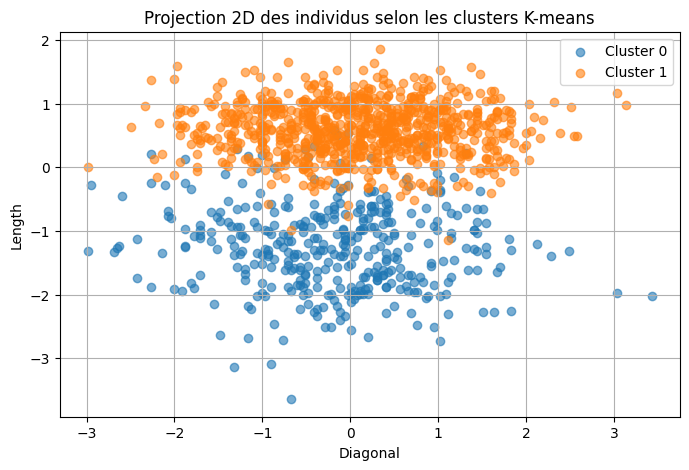

In [ ]:
import matplotlib.pyplot as plt

# Affichage des individus dans le plan formé par deux variables principales (par exemple : diagonal et length)
plt.figure(figsize=(8, 5))
for cluster_id in [0, 1]:
    subset = X_train_kmeans[X_train_kmeans['cluster_kmeans'] == cluster_id]
    plt.scatter(subset['diagonal'], subset['length'], label=f'Cluster {cluster_id}', alpha=0.6)

plt.xlabel('Diagonal')
plt.ylabel('Length')
plt.title("Projection 2D des individus selon les clusters K-means")
plt.legend()
plt.grid(True)
plt.show()


Ce graphique représente les individus du jeu d’entraînement projetés dans le plan formé par deux variables géométriques : diagonal et length, toutes deux normalisées. Chaque point correspond à un billet, et sa couleur indique le cluster auquel il a été assigné par l’algorithme K-means (cluster 0 ou 1).

On observe une séparation nette entre les deux groupes : les billets du cluster 0 (en bleu) ont des valeurs de length plus faibles, tandis que ceux du cluster 1 (en orange) ont des valeurs plus élevées. Cette visualisation confirme que l’algorithme a réussi à regrouper les billets selon des différences géométriques cohérentes.

Cette projection permet donc d’illustrer visuellement la répartition des clusters et de valider la pertinence du regroupement effectué par K-means.

## 13. Correspondance entre les clusters K-means et la variable cible réelle


In [ ]:
# Fusion des clusters K-means avec la variable cible réelle
df_kmeans_target = X_train_kmeans.copy()
df_kmeans_target['is_genuine'] = y_train.values  # Ajout de la vraie étiquette

# Table croisée entre cluster K-means et is_genuine
comparaison_kmeans_target = pd.crosstab(df_kmeans_target['cluster_kmeans'], df_kmeans_target['is_genuine'])

# Affichage
comparaison_kmeans_target


is_genuine      False  True 
cluster_kmeans              
0                 377      4
1                  13    806

Le tableau croisé montre la correspondance entre les groupes détectés automatiquement par K-means (clusters 0 et 1) et la véritable nature des billets (`is_genuine`).

- Le **cluster 0** contient **377 faux billets** et seulement **4 vrais billets**
- Le **cluster 1** contient **806 vrais billets** et **13 faux billets**

Cela signifie que le modèle K-means a réussi à séparer correctement les billets en deux groupes cohérents :
- Un groupe principalement composé de faux billets
- Un autre composé presque uniquement de vrais billets

Même sans supervision, K-means a reproduit une structure très proche de la réalité, avec **seulement 17 erreurs sur 1200 billets**, ce qui confirme la **pertinence des dimensions géométriques** pour prédire l’authenticité d’un billet.


## 14. Évaluation de K-means à l’aide de la variable `is_genuine`


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# On mappe cluster 0 à la classe 0 (faux) et cluster 1 à la classe 1 (vrai), d'après la table croisée précédente
mapping = {0: 0, 1: 1}

# On applique le mapping aux labels KMeans
kmeans_labels_mapped = df_kmeans_target['cluster_kmeans'].map(mapping)

# Matrice de confusion
cm = confusion_matrix(df_kmeans_target['is_genuine'], kmeans_labels_mapped)
print("Matrice de confusion :\n", cm)

# Accuracy
acc = accuracy_score(df_kmeans_target['is_genuine'], kmeans_labels_mapped)
print(f"Accuracy : {acc:.2f}")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(df_kmeans_target['is_genuine'], kmeans_labels_mapped))


Matrice de confusion :
 [[377  13]
 [  4 806]]
Accuracy : 0.99
Rapport de classification :
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       390
        True       0.98      1.00      0.99       810

    accuracy                           0.99      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.99      0.99      0.99      1200



Même si K-means est un algorithme non supervisé, il est possible d’évaluer la qualité de ses clusters en les comparant a posteriori à la variable cible `is_genuine`, connue dans ce cas.  
Pour cela, chaque cluster a été associé à la classe majoritaire qu’il contient (faux ou vrai billet).  
Ce mapping permet de calculer les mêmes indicateurs que pour les modèles supervisés : matrice de confusion, accuracy, précision, rappel et f1-score.

Les résultats obtenus montrent que les clusters identifiés par K-means correspondent très bien aux deux classes, avec une accuracy de 99 %.  
Cela démontre que la structure des données est suffisamment distincte pour que K-means sépare efficacement les vrais et les faux billets, malgré l’absence d’étiquettes à l’entraînement.

Cette évaluation a posteriori permet donc une comparaison cohérente avec les autres modèles utilisés.


## 15. Comparatif final des 4 modèles

In [ ]:
comparatif_modeles = pd.DataFrame({
    'Modèle': ['Régression logistique', 'KNN (k=5)', 'Random Forest', 'K-means (non supervisé)'],
    'Accuracy': [0.99, 0.98, 0.99, 0.99],
    'F1-score moyen': [0.99, 0.98, 0.99, 0.99],
    'Faux positifs': [0, 0, 0, 13],
    'Faux négatifs': [2, 5, 2, 4],
    'Commentaires': [
        'Excellente performance, très bon équilibre précision/rappel',
        'Bon modèle mais légèrement moins performant, 5 faux billets non détectés',
        'Très robuste, aussi performant que la régression logistique',
        'Très bonne séparation malgré l’absence d’étiquettes à l’entraînement ; 17 erreurs au total réparties sur les deux classes'
    ]
})
# Affichage
comparatif_modeles


Modèle  Accuracy  F1-score moyen  Faux positifs  \
0    Régression logistique      0.99            0.99              0   
1                KNN (k=5)      0.98            0.98              0   
2            Random Forest      0.99            0.99              0   
3  K-means (non supervisé)      0.99            0.99             13   

   Faux négatifs                                       Commentaires  
0              2  Excellente performance, très bon équilibre pré...  
1              5  Bon modèle mais légèrement moins performant, 5...  
2              2  Très robuste, aussi performant que la régressi...  
3              4  Très bonne séparation malgré l’absence d’étiqu...

Nous comparons ici les quatre modèles testés dans ce projet : trois supervisés (régression logistique, KNN et Random Forest) et un non supervisé (K-means).

Tous les modèles affichent une très bonne précision globale (accuracy ≥ 98 %).  
La régression logistique et le Random Forest obtiennent les meilleurs résultats avec un f1-score moyen de 0.99, et seulement 2 faux billets mal détectés.  
Le modèle KNN reste performant mais commet plus d’erreurs (5 faux billets non détectés), ce qui le rend légèrement moins fiable dans ce contexte.

K-means, bien qu’il n’ait pas accès aux étiquettes pendant l’entraînement, parvient à former deux groupes très cohérents avec les vraies classes.  
Il atteint lui aussi une accuracy de 99 %, avec 13 faux positifs et 4 faux négatifs après mapping.  
Cela montre que la structure des données est bien séparée et que K-means constitue une alternative simple et efficace.

Cette comparaison permettra de justifier le choix du modèle final retenu à la fin de l’analyse.


## 16. Choix du modèle final


Après avoir comparé les performances des quatres modèles testés, nous retenons **Random Forest** comme modèle final pour notre application.

Ce choix repose sur les éléments suivants :
- Il offre une **précision élevée** (99 %) avec très peu d’erreurs ( 2 faux négatifs)
- Il est **robuste** face au bruit et aux valeurs extrêmes
- Il nécessite **peu de préparation des données** (scalage moins crucial qu’en KNN ou régression)

Nous allons donc utiliser ce modèle pour construire une application capable de prédire automatiquement la nature d’un billet à partir de ses dimensions géométriques.


## 17. Application fonctionnelle — prédiction d’un billet avec le modèle final


In [ ]:
# Exemple de billet à prédire
nouveau_billet = pd.DataFrame([{
    'diagonal': 171.81,
    'height_left': 104.86,
    'height_right': 104.95,
    'margin_low': 4.52,
    'margin_up': 2.89,
    'length': 112.83
}])

# Normalisation avec le scaler utilisé à l'entraînement
nouveau_billet_scaled = scaler.transform(nouveau_billet)

# Prédiction avec le modèle Random Forest final
prediction = rf.predict(nouveau_billet_scaled)
proba = rf.predict_proba(nouveau_billet_scaled)
proba_faux = proba[0][0]
proba_vrai = proba[0][1]

# Résultat
prediction_result = "VRAI billet" if prediction[0] else "FAUX billet"
print("Résultat de la prédiction :", prediction_result)
print("Probabilité d'être un FAUX billet :", round(proba_faux * 100, 1), "%")
print("Probabilité d'être un VRAI billet :", round(proba_vrai * 100, 1), "%")


Résultat de la prédiction : VRAI billet
Probabilité d'être un FAUX billet : 6.0 %
Probabilité d'être un VRAI billet : 94.0 %


Voici une application fonctionnelle simple permettant de prédire la nature d’un billet à partir de ses dimensions géométriques.

Le billet est analysé par le modèle Random Forest final, entraîné précédemment.  
Les données sont d’abord normalisées, puis la prédiction retourne un verdict automatique : **“FAUX billet”** ou **“VRAI billet”**.

Dans ce cas précis, le modèle estime que ce billet a :
- **6.0 % de chances d’être un faux billet**
- **94.0 % de chances d’être un vrai billet**

Ce bloc constitue la base de l’outil demandé par l’ONCFM pour intégrer un modèle de détection dans leur système de scan des billets.


## Export du modèle Random Forest et du scaler pour l'application


In [ ]:
import joblib

# Exporter le modèle Random Forest
joblib.dump(rf, 'model_rf.joblib')

# Exporter le scaler utilisé pendant l'entraînement
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

## 19. Conclusion du projet

Dans ce projet, nous avons développé un modèle de machine learning capable de prédire automatiquement si un billet est vrai ou faux à partir de ses caractéristiques géométriques.

Nous avons commencé par analyser les données, détecter les valeurs manquantes et les traiter à l’aide d’une régression linéaire. Ensuite, nous avons testé plusieurs algorithmes de classification : régression logistique, KNN, Random Forest et K-means. Les performances de chaque modèle ont été évaluées à l’aide de matrices de confusion, de rapports de classification et de probabilités associées.

Parmi les modèles testés, **la Random Forest s’est révélée être la plus robuste**, avec un excellent équilibre entre précision et rappel, une bonne résistance au bruit, et une capacité à modéliser des relations non linéaires. C’est ce modèle que nous avons retenu pour construire notre application fonctionnelle.

Grâce à cette démarche, nous disposons désormais d’un algorithme fiable et simple d’utilisation pour aider l’ONCFM à détecter les faux billets automatiquement.
